# Intro
We are Ram (123) and Or (315339960), and in this notebook, we are going to talk about data from 911 calls. We have looked far and wide for a dataset that has enough "meat" for a nice EDA, in a field that is interesting to us, and where we believed we could train an interesing model. Our research has led us to this [Kaggle Dataset](https://www.kaggle.com/datasets/louisteitelbaum/911-recordings-first-6-seconds).

## About 911
The 911 hotline, a pivotal component of emergency response systems in the United States and various other countries, is a three-digit phone number primarily designed for immediate access to emergency services. Established in 1968, the 911 hotline has evolved to become a critical lifeline, connecting individuals in distress with swift assistance from law enforcement, fire departments, and medical professionals. Its importance cannot be overstated, as it serves as the first point of contact in times of crisis, enabling efficient coordination of resources and reducing response times. Its historical significance, coupled with its ever-increasing relevance in the digital age, underscores the importance of continually optimizing and leveraging data-driven approaches to ensure the safety and well-being of communities.

## About the dataset
This dataset contains a collection of usunsual or critical calls, including the full audio version of them. It also has a .csv table which includes features like title, state, number of casualities, was this call a false alarm etc. While invasive, and at times very difficult to go through, the subject matter was both interesting and important, as using data science to improve upon the existing system of the 911 hotline could help to save lives. The dataset consists of around 700 calls, including full audio of the calls. While not the largest 911 call sample, the availability of the original voice recordings drew us to analyze this dataset - Because 
1. using voice recordings increased the range of applications that we could think of to include real-time audio processing, for example have an active assistant that could highlight whether or not this call sounds dangerous.
2. we were interested in analyzing audio data as part of this project

We didn't start with a clear model in mind, and first went to analyze what we can and can't do with the data. Right off the bat however, we saw some difficulties in trying to apply what we do here to real-life situations:
- The dataset is rather small, consisting of only 700 calls.
- The dataest is hand selected by a senior operator to train new 911 operators. Therefore, this dataset is skewed towards irregular calls, so using this data to correctly make predictions about random 911 calls could lead to bad results, and be skewed towards making false positives.
However, we hope the work we do here can provide a good proof of concept that could perhaps be extended upon with access to a larger dataset.


# The Problem - #TODO: maybe move this section?
911 gets around 657,000 calls, every single day in the US. This means thousands upon thousands of operators are needed, and they must perform flawlessly for hunderds of calls each and every day, with the extreme pressure that if they make a mistake - it could cost someone's life.
Right now the operator has to sift through all of those calls, and try to understand if every one of the callers is in real danger or not. Also, in many instances, the caller who is in danger might not want to reveal he is talking to 911, so he could be talking in code. The operator must differentiate between those who are in danger, to those who mixed up 911 with Domino's number.

We propose to make a model that can make their lives easier in several ways. 
For one, it can also listen in to the call with the operator, and try to make suggestions, to determine whether or not to send a police car to the call's location. Also, it can be used to determine whether or not the call was a false alarm. 
It can serve as an assistant to the operator, to help them reduce the amount of mistakes they make.


## Setup
Let's keep the imports and setup here:

In [60]:
# Some installtions here:
!pip3 install -r ./requirements.txt --quiet

In [61]:
# Imports and setup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import YearLocator, DateFormatter
import itertools
import random

sns.set_palette("pastel")
palette = itertools.cycle(sns.color_palette())
random.seed(42)


# EDA

First off, let's have a look at a sample of our data, so we can see the different columns that we have and examples of what they contain:

In [77]:
# load the dataset
df = pd.read_csv('911_metadata.csv')
print(f"total rows: {len(df)}")
df.head(5)

total rows: 710


,id,event_id,link,title,date,state,deaths,potential_death,false_alarm,description,deaths_binary,break,filename
0,0,2,https://web.archive.org/web/20150417085342/htt...,Detroit Child’s 911 Call – audio,2/06,Michigan,1.0,1.0,0.0,– In Feb. 2006 5 year-old Robert Turner called...,1,13.0,911_first6sec/call_2_0.wav
1,1,8,https://web.archive.org/web/20150417085342/htt...,Girl’s Murder 911 Call,3/05,Florida,2.0,1.0,0.0,– the 911 call of a lifetime. Volusia County (...,1,3.0,911_first6sec/call_8_0.wav
2,2,9,https://web.archive.org/web/20150417085342/htt...,‘Shoot Her?’ 911 call,4/05,Texas,0.0,0.0,1.0,– caller reports her daughter is creating a di...,0,2.0,911_first6sec/call_9_0.wav
3,3,10,https://web.archive.org/web/20150417085342/htt...,Snowstorm 911 Call,1/05,Nebraska,2.0,1.0,0.0,– a couple under the influence of drugs dialed...,1,0.0,911_first6sec/call_10_0.wav
4,4,11,https://web.archive.org/web/20150417085342/htt...,911 Call for a Date,1/06,Oregon,0.0,0.0,1.0,– Lorna Jeanne Dudash in Aloha (Ore.) dialed 9...,0,2.0,911_first6sec/call_11_0.wav


From this ~700 rows dataset, we have information about which state the call was made from, what month it happened in, was it a false alarm, how many people died as the result of the event (also available as a boolean), "break" - which is, how many seconds into the call the recording was made and a general title and description of what happened.
We also have the link to the original call audio file, which we will use later.

## Cleaning the data

Let's start by trying to deduplicate by the id field:

In [63]:
df_clean = df.drop_duplicates(subset=['id'])
print(f"total dataset count after deduplication: {len(df_clean)}")

total dataset count after deduplication: 710


It appears there are no duplications - however, let's also try to deduplicate by the "link" column, which should have unique values as the calls should be different:

In [64]:
df_clean = df.drop_duplicates(subset=['link'])
print(f"total dataset count after deduplication: {len(df_clean)}")

total dataset count after deduplication: 644


Ah-ha! So, it seems like there are duplicates after all - let's see an example of a duplicate to see if there is anything we can learn from them:

In [65]:
dup_vc = df.value_counts(['link'])
print(dup_vc)

link                                                                                                                  
https://web.archive.org/web/20150417085348/http://mp3.911dispatch.com.s3.amazonaws.com/murfreesboro_tornado_911.mp3       7
https://web.archive.org/web/20150417085342/http://mp3.911dispatch.com.s3.amazonaws.com/non_emerg_911s.mp3                 6
https://web.archive.org/web/20150417085349/http://mp3.911dispatch.com.s3.amazonaws.com/west_explosion_911.mp3             6
https://web.archive.org/web/20150417085351/http://mp3.911dispatch.com.s3.amazonaws.com/jerseycity_af1_911.mp3             4
https://web.archive.org/web/20150417085349/http://pdf.911dispatch.com.s3.amazonaws.com/clackamas_mall_shooting_911.mp3    4
                                                                                                                         ..
https://web.archive.org/web/20150417085338/http://www.911dispatch.com/reference/fortwayne_burglary_911.mp3                1
https://web.a

Let's look at the entries for the top link:

In [66]:
df[df['link'] == 'https://web.archive.org/web/20150417085348/http://mp3.911dispatch.com.s3.amazonaws.com/murfreesboro_tornado_911.mp3']

,id,event_id,link,title,date,state,deaths,potential_death,false_alarm,description,deaths_binary,break,filename
511,511,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,11.000,911_first6sec/call_552_0.wav
512,512,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,48.000,911_first6sec/call_552_1.wav
513,513,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,75.000,911_first6sec/call_552_2.wav
514,514,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,138.000,911_first6sec/call_552_3.wav
515,515,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,195.000,911_first6sec/call_552_4.wav
516,516,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,215.228,911_first6sec/call_552_5.wav
517,517,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,250.000,911_first6sec/call_552_6.wav


The only difference between entries was the 'break' column, which is the second at which the 6-second sample from the call has started. In other words - we have several timestamps from the call. We will need to take this into account when training our model.

Let's continue with the data cleaning process - Looking at the above sample, it appears "4/09" was used for April 2009. so we have month-granularity dates, but the format is not a valid python datetime format. let's add a leading zero to make this a datetime compatible format:

In [67]:

# Transform the date from string to datetime
def add_leading_zero(date_str):
    if date_str is None:
        return ''
    if len(date_str) < 5:
        return '0' + date_str
    else:
        return date_str

# Apply the function add_leading_zero to the 'date' column to make sure it starts with a 0
df_clean['date_dt'] = pd.to_datetime(df['date'].astype(str).apply(add_leading_zero), format='%m/%y', errors='coerce')
df_clean['date_dt']

/var/folders/l2/mb5swst9595c32g7m12q0xf80000gn/T/ipykernel_26613/1933772912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['date_dt'] = pd.to_datetime(df['date'].astype(str).apply(add_leading_zero), format='%m/%y', errors='coerce')


0     2006-02-01
1     2005-03-01
2     2005-04-01
3     2005-01-01
4     2006-01-01
         ...    
705   2010-08-01
706   2010-08-01
707   2010-08-01
708   2010-08-01
709   2010-09-01
Name: date_dt, Length: 644, dtype: datetime64[ns]

Good - we have valid dates now.
Let's also convert all boolean columns to boolean values:

In [86]:
dfc = df_clean.copy()
df_clean.loc[:, 'false_alarm'] = dfc['false_alarm'].replace({1: True, 0: False})
df_clean.loc[:, 'potential_death'] = dfc['potential_death'].replace({1: True, 0: False})
df_clean.loc[:, 'deaths_binary'] = dfc['deaths_binary'].replace({1: True, 0: False})

,id,event_id,link,title,date,state,deaths,potential_death,false_alarm,description,deaths_binary,break,filename,date_dt
0,0,2,https://web.archive.org/web/20150417085342/htt...,Detroit Child’s 911 Call – audio,2/06,Michigan,1.0,True,False,– In Feb. 2006 5 year-old Robert Turner called...,True,13.0,911_first6sec/call_2_0.wav,2006-02-01
1,1,8,https://web.archive.org/web/20150417085342/htt...,Girl’s Murder 911 Call,3/05,Florida,2.0,True,False,– the 911 call of a lifetime. Volusia County (...,True,3.0,911_first6sec/call_8_0.wav,2005-03-01
2,2,9,https://web.archive.org/web/20150417085342/htt...,‘Shoot Her?’ 911 call,4/05,Texas,0.0,False,True,– caller reports her daughter is creating a di...,False,2.0,911_first6sec/call_9_0.wav,2005-04-01
3,3,10,https://web.archive.org/web/20150417085342/htt...,Snowstorm 911 Call,1/05,Nebraska,2.0,True,False,– a couple under the influence of drugs dialed...,True,0.0,911_first6sec/call_10_0.wav,2005-01-01
4,4,11,https://web.archive.org/web/20150417085342/htt...,911 Call for a Date,1/06,Oregon,0.0,False,True,– Lorna Jeanne Dudash in Aloha (Ore.) dialed 9...,False,2.0,911_first6sec/call_11_0.wav,2006-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,705,739,https://web.archive.org/web/20150417085349/htt...,Prank call,8/10,California,0.0,False,True,– In August 2010 a Los Angeles County sheriff’...,False,26.0,911_first6sec/call_739_0.wav,2010-08-01
706,706,740,https://web.archive.org/web/20150417085349/htt...,Call from murder suspect,8/10,California,0.0,True,False,– In August 2010 the suspect in the murder of ...,False,10.0,911_first6sec/call_740_0.wav,2010-08-01
707,707,741,https://web.archive.org/web/20150417085349/htt...,Shoot-out,8/10,Georgia,2.0,True,False,– In August 2010 an ex-boyfriend arrived at a ...,True,16.0,911_first6sec/call_741_0.wav,2010-08-01
708,708,742,https://web.archive.org/web/20150417085349/htt...,Murders,8/10,Arizona,6.0,True,False,– In Aug. 2010 a man invaded the Lake Havasu (...,True,18.0,911_first6sec/call_742_0.wav,2010-08-01


## Exploring the data
### State
As we can see, we have data about which state in the U.S. the call was made from.

Let's look how many valid values of state we have:

In [69]:
df_with_state = df_clean.dropna(subset=['state'])
print(f"total data points with missing state: {len(df_clean) - len(df_with_state)}")

total data points with missing state: 3


In [70]:
# All state values sorted:
df_with_state['state'].sort_values().unique()

array(['Alaska', 'Arizona', 'Arkansas', 'California', 'Canada',
       'Colorado', 'Connecticut', 'DC', 'Florida', 'Georgia', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Jersey',
       'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'South Carolina',
       'Tennessee', 'Texas', 'Utah', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin'], dtype=object)

As expected, we have a variety of U.S states. However, we also have Canada. 
Let's plot this on a map of the US to get a picture of possible hot spots (Note we are not including Alaska and Canada to keep the map more readable):

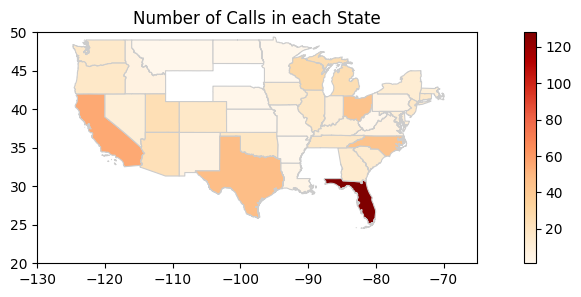

In [87]:
# Let's break it down by state
state_counts = df['state'].value_counts().reset_index()
state_counts.columns = ['state', 'count']
us_states = gpd.read_file('cb_2018_us_state_500k.shp')
us_states = us_states.merge(state_counts, left_on='NAME', right_on='state', how='left')
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
us_states.plot(column='count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title(f"Number of Calls in each State")
ax.set_xlim(-130,-65)
ax.set_ylim(20,50)
plt.show()


Florida, California, and Texas seem to lead, though it's no wonder considering the amount of people within these states, though in general the data seems pretty well distributes. Let's try to find out the state with the most calls per 1M people:

(20.0, 50.0)

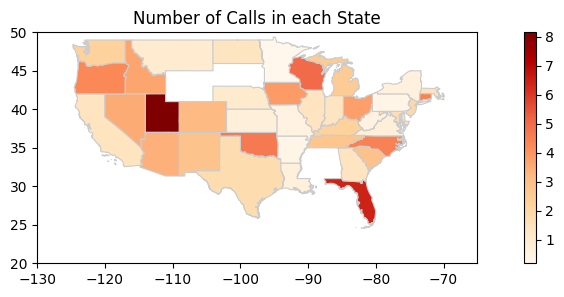

In [90]:
# load a dataset with the population of each state
state_csv = pd.read_csv('https://gist.githubusercontent.com/bradoyler/0fd473541083cfa9ea6b5da57b08461c/raw/fa5f59ff1ce7ad9ff792e223b9ac05c564b7c0fe/us-state-populations.csv')
us_states_with_pop = us_states.merge(state_csv, left_on='STUSPS', right_on='code', how='left')
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
us_states_with_pop['calls_per_1M'] = (us_states_with_pop['count'] / us_states_with_pop['pop_2014']) * 1000000
us_states_with_pop.plot(column='calls_per_1M', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title(f"Number of Calls in each State")
ax.set_xlim(-130,-65)
ax.set_ylim(20,50)

The above map gives us a more accurate map of where there are more "dangerous" calls. 
Although 600 calls is a low number to have clear-cut conclusions from, seems like Utah and Florida have the most cases.
Of course, we shouldn't forget about Canada and Alaska:


In [91]:
print(f"{len(df_clean[df_clean['state'] == 'Canada'])} calls from Canada")
canada_population_millions = 37.59
print(f"{len(df_clean[df_clean['state'] == 'Canada']) / canada_population_millions} calls per 1M people in Canada")

print(f"{state_counts[state_counts['state'] == 'Alaska']['count'].values[0]} calls from Alaska")
print(f"{us_states_with_pop[us_states_with_pop['NAME'] == 'Alaska']['calls_per_1M'].values[0]} calls per 1M people in Alaska")



4 calls from Canada
0.10641127959563713 calls per 1M people in Canada
1 calls from Alaska
1.3573456833692579 calls per 1M people in Alaska


All in all, a pretty insignificant number of calls for Canada and Alaska.

### False Alarm
Next, let's take a look at the false alarm column, to figure out how much data tagged as false alarm do we have:

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

<Figure size 800x600 with 0 Axes>

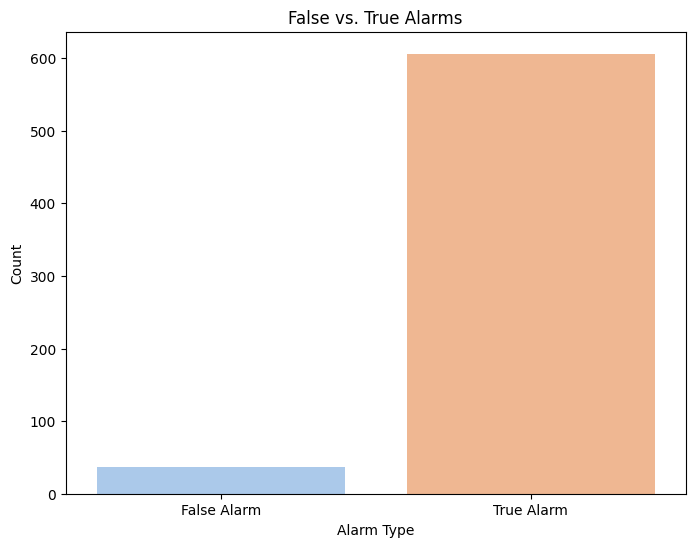

In [74]:
g = sns.countplot(x='false_alarm', data=df_clean)
g.set_xticklabels(['True Alarm', 'False Alarm'])
g.set_xlabel('')
g.set_ylabel('Count')
g.set_title('False vs. True Alarms')
plt.show()


Seems like the vast majority of the calls were not, in fact, false alarms. Which could pose a problem if we were to try and detect whether or not a call was a false alarm with our model.

### Deaths
Let's also look at how many calls resulted in deaths:

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


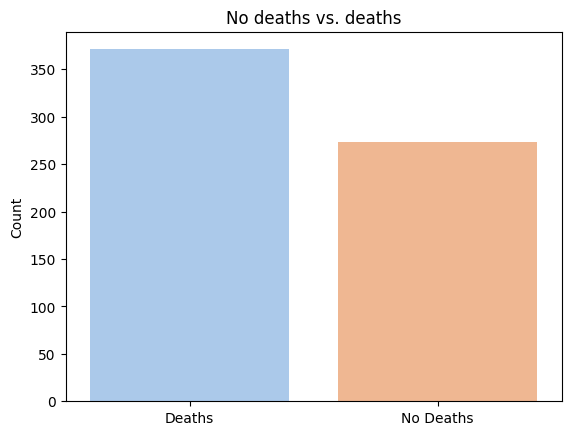

In [113]:
g = sns.countplot(x='deaths_binary', data=df_clean)
g.set_xticklabels(['Deaths', 'No Deaths'])
g.set_xlabel('')
g.set_ylabel('Count')
g.set_title('No deaths vs. deaths')

plt.show()


Seems like in general, the feature is pretty balanced, though there are a bit more calls that resulted in one more death. 
Let's combine the "deaths_binary" and "false alarm" features to split the data into 4 categories:
1. true_alarm_death - deadly cases, which can indicate a failure of the opeartor, or a hopeless case.
2. false_alarm_death - If cases like these exist, they can indicate a corruption of data of one of the columns - either there was no death, or it was a true alarm. 
3. true_alarm_no_death - Cases that were potentially stopped by the operator
4. false_alarm_no_death - Cases where it was truly a false alarm.


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

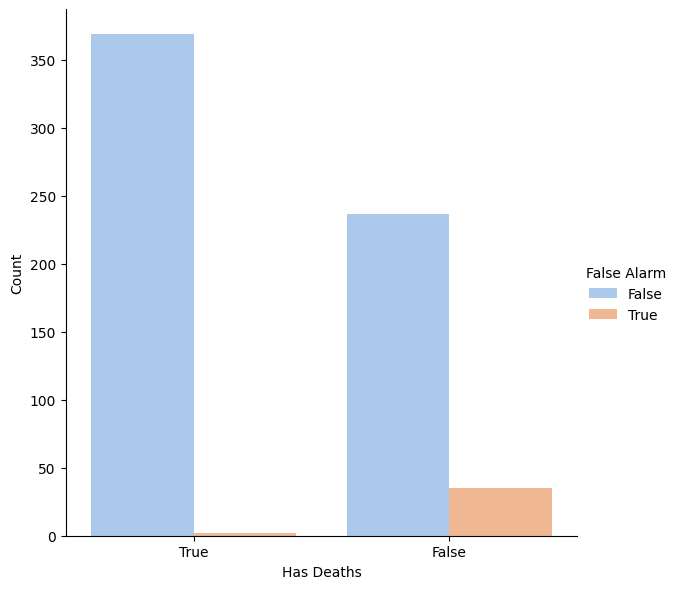

In [103]:
df_clean_str = df_clean.copy()
df_clean_str['false_alarm'] = df_clean['false_alarm'].replace({True: 'True', False: 'False'})
df_clean_str['deaths_binary'] = df_clean['deaths_binary'].replace({True: 'True', False: 'False'})

g = sns.catplot(
    data=df_clean, kind="count",
    x="deaths_binary",
    hue="false_alarm",
    height=6
)
g.set_axis_labels("Has Deaths", "Count")

g.legend.set_title("False Alarm")
# plt.tight_layout()
plt.show()


Hmm. seems like a small amount of the results have deaths while also being tagged as a false alarm. From the datasets description about "false_alarm" feature: "Additional metadata (date, state, citizen initiated, deaths, potential death, and false alarm) were manually coded based on the descriptions, recordings, and additional news sources". So, seems like it isn't entirly trustworthy right? let's see the datapoints themselves:

In [ ]:
# Get data points with deaths_binary = True and false_alarm = True
df_deaths_false_alarm = df_clean[(df_clean['deaths_binary'] == True) & (df_clean['false_alarm'] == True)]
# Only two data points
print(df_deaths_false_alarm['description'].values[0])
print(df_deaths_false_alarm['description'].values[1])

– In Jan. 2011 a man walked into the Monroe Falls (Ohio) police department lobby, dialed 911 from a cellular and confessed to strangling his sister. Lawrence Hanly was arrested by officers without incident.
– Olidia Day fled in her car from her ex-boyfriend when he arrived at her home. She dialed 911 for help and reached a Sunrise (Fla.) dispatcher, and then drove to the Plantation police station, where she was shot and killed by the man, who then killed himself. A controversy followed about the calltaker’s performance, and the incident was highlighted on a “Dr. Phil” episode.


The incidents appear very much real, and look like it was a True alarm indeed.

### Potential deaths
Let's have a look at the distribution:

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


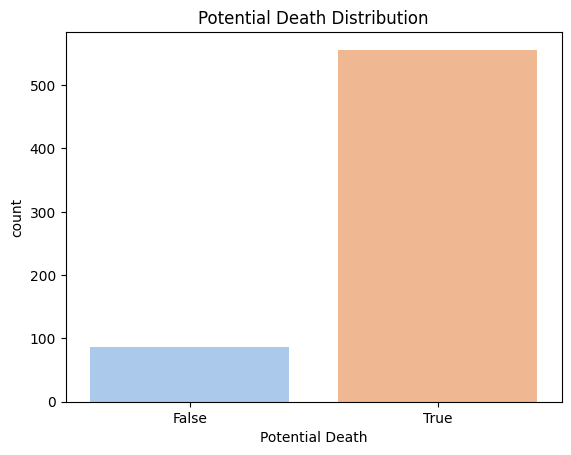

In [105]:
# show distribution of column potential_death
g = sns.countplot(x='potential_death', data=df_clean)
g.set_title("Potential Death Distribution")
g.set_xlabel("Potential Death")

plt.show()

Let's also break it down by potential death and deaths_bool, to try and find discrepencies in the data:

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

AttributeError: 'bool' object has no attribute 'startswith'

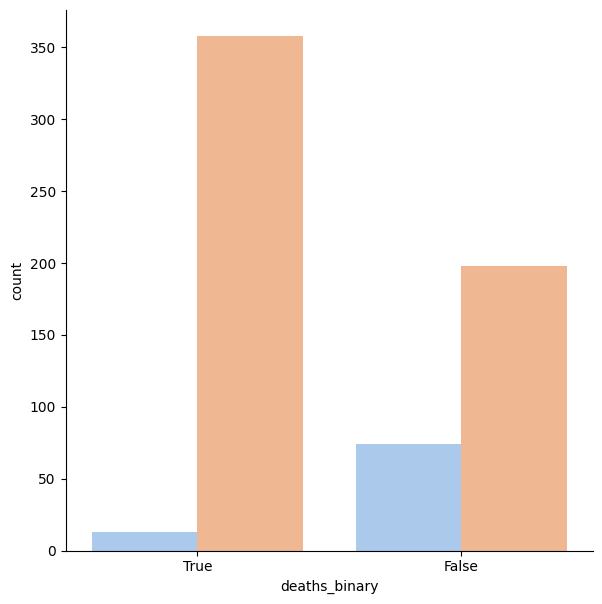

In [117]:
g = sns.catplot(
    data=df_clean_str, kind="count",
    x="deaths_binary",
    hue="potential_death",
    height=6
)
g.set_axis_labels("Has Deaths", "Count")
g.legend.set_title("Potential Death")
# set legend in upper left corner
# plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

So, there are several cases where there are deaths in spite of no death potential. Let's have a look at the data to determine the cause:

Next, let's see the spread death count in the dataset:

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


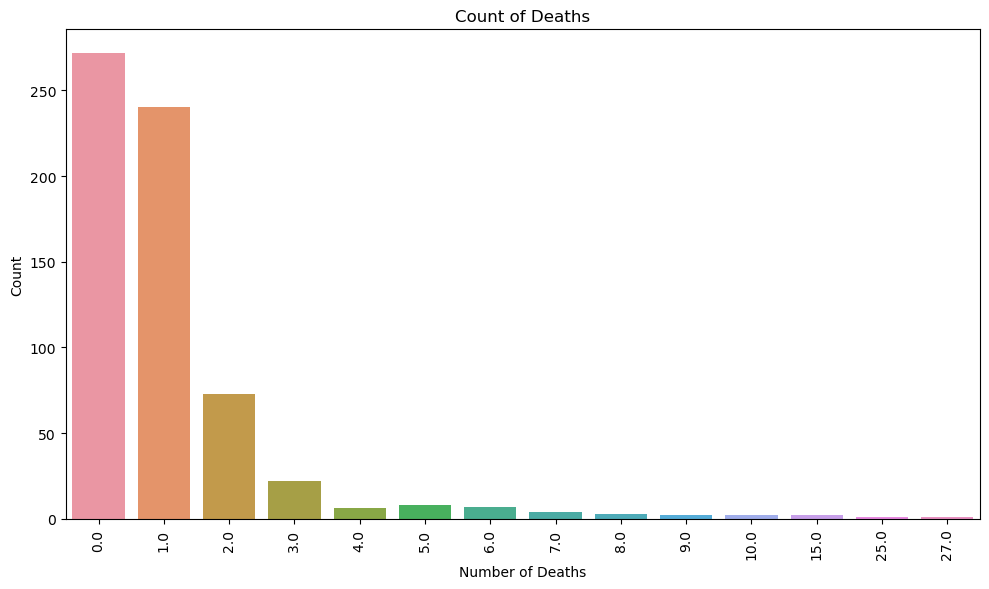

In [ ]:
# Create a count plot of the 'deaths' column
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='deaths')
plt.xlabel('Number of Deaths')
plt.ylabel('Count')
plt.title('Count of Deaths')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


As we can see, most of the calls have 0-1 deaths, and a minority have more than 2.

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

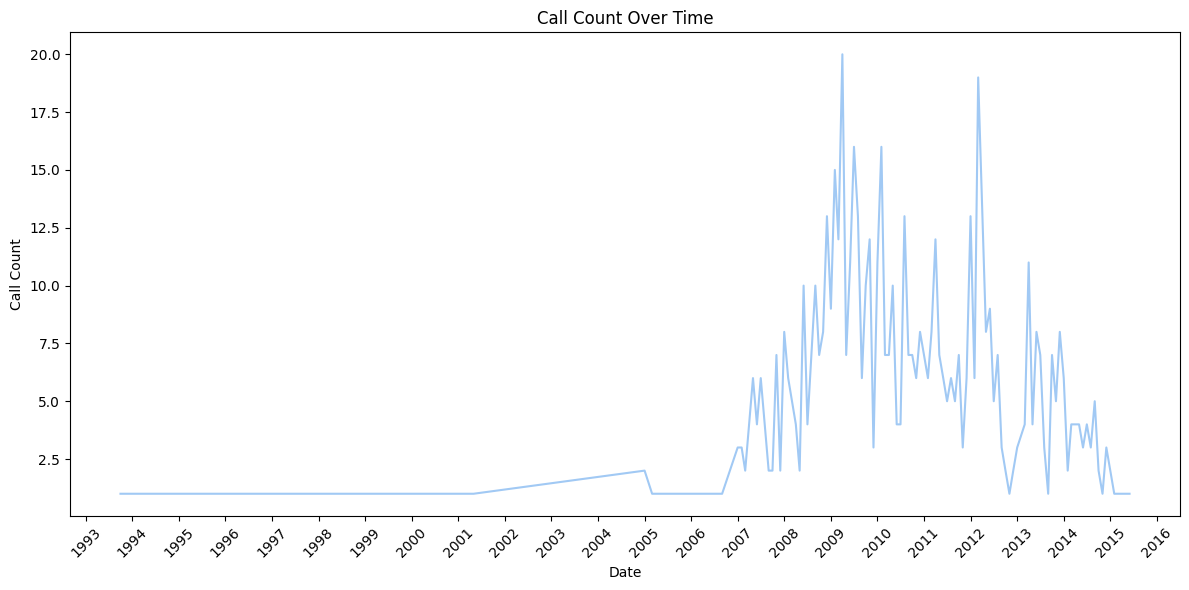

In [ ]:
# Group the data by date and count the calls for each date
calls_by_date = df_clean.groupby('date_dt')['id'].count().reset_index()
years_locator = YearLocator(base=1)
years_format = DateFormatter('%Y')


# Create a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=calls_by_date, x='date_dt', y='id')

plt.gca().xaxis.set_major_locator(years_locator)
plt.gca().xaxis.set_major_formatter(years_format)

plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Call Count')
plt.title('Call Count Over Time')
plt.tight_layout()
plt.show()


Another attribute we have is the "break" column, which tells us how long into the call the audio snippet begins. Let's see it plotted:

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

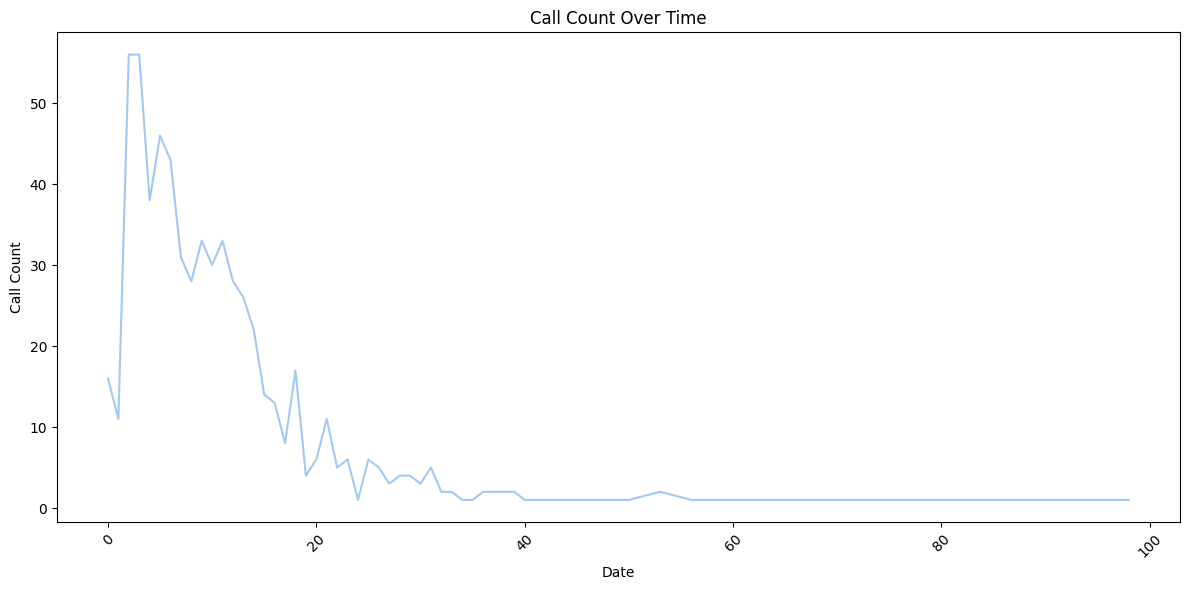

In [ ]:
# Group the data by date and count the calls for each date
calls_by_break = df_clean.groupby('break')['id'].count().reset_index()

# Create a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=calls_by_break, x='break', y='id')

plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Call Count')
plt.title('Call Count Over Time')
plt.tight_layout()
plt.show()


So while the vast majority of calls are from the very beginning of the call, some aren't. We should keep this in mind in case our model will assume the calls are actually the first 6 seconds, as the name of the dataset suggests.

## Exploring the Audio

In [123]:
df['link'].values()[9]

TypeError: 'numpy.ndarray' object is not callable